#**Подключение пакетов**

In [ ]:
!pip install bootstrapped

  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=6d713bcf4c9c51b16c1a6c22981cad9bce489fd30ce6a86d8c37ef33a663f89e
  Stored in directory: /root/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped


In [ ]:
import pandas as pd
import pylab 
import numpy as np
import scipy.stats as stats
import statsmodels.api
from matplotlib import pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Выбор метрик** 

В данном задании, так как требуется анализ методом bootstrap, разумно рассмотреть метрики, которые уже представлены в таблице, то есть: metric_value, users, visits, churn_users, churn_visits. Однако для каждой метрики способы анализа будут разными. Например, metric_value, как будет видно далее, вполне нормально распределенная количественная характеристика и для нее вполне можно применять классические методы анализа (в любом случае, попробуем использовать метод bootstrap и для нее).

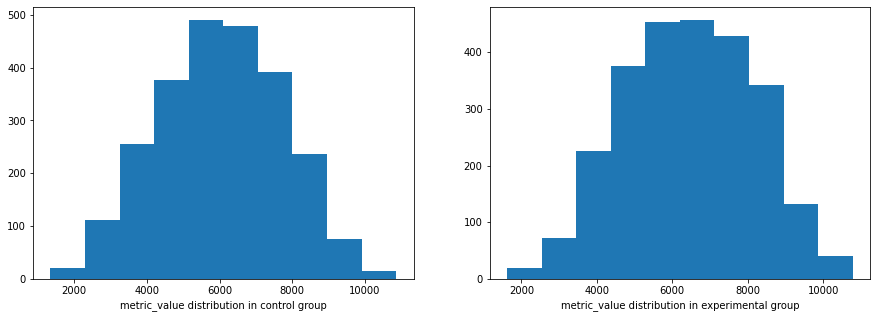

In [ ]:
users = pd.read_csv("hw_abt_2_byuser.csv", sep="\t")
ctrl_group = users[users["group"] == "A"]
test_group = users[users["group"] == "B"]

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(ctrl_group.metric_value.values)
ax2.hist(test_group.metric_value.values)

ax1.set_xlabel("metric_value distribution in control group")
ax2.set_xlabel("metric_value distribution in experimental group")

plt.show()

С другой стороны, метрики visits и churn_visits имеют явно выраженные ассиметрии в своих распределениях - для них bootstrap выглядит наиболее подходящим. 

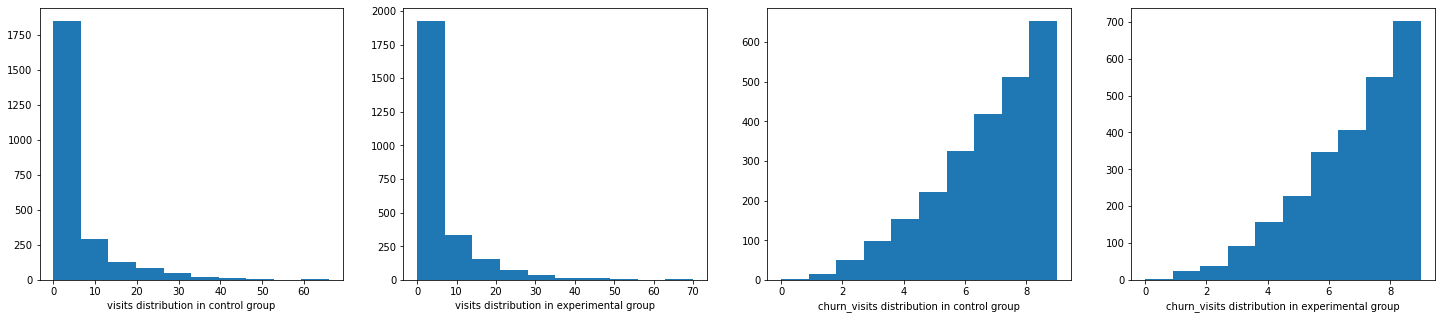

In [ ]:
fig = plt.figure(figsize=(25, 5))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.hist(ctrl_group.visits.values)
ax2.hist(test_group.visits.values)
ax3.hist(ctrl_group.churn_visits.values)
ax4.hist(test_group.churn_visits.values)

ax1.set_xlabel("visits distribution in control group")
ax2.set_xlabel("visits distribution in experimental group")
ax3.set_xlabel("churn_visits distribution in control group")
ax4.set_xlabel("churn_visits distribution in experimental group")

plt.show()

Наконец, метрики users и churn_users являются бинарными. Метод их анализа будет изложен позже.

#**Нормальность и гомоскедастичность распределений**

Убедимся в том, что метрика **metric_value** распределена нормально как в контрольной, так и в тестовой группе, а также проведем дисперсионный анализ для данных групп. В данном случае выборки довольно большие и критерии согласия будут плохо работать. Есть смысл посмотреть на qq-plot.

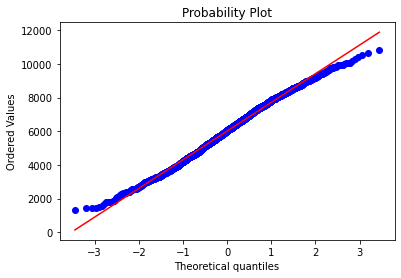

In [ ]:
stats.probplot(ctrl_group.metric_value.values, dist="norm", plot=pylab)
pylab.show()

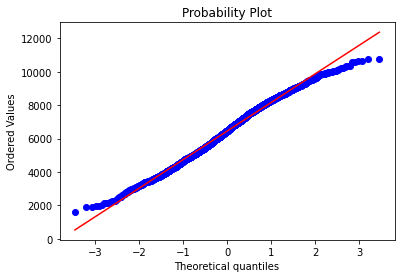

In [ ]:
stats.probplot(test_group.metric_value.values, dist="norm", plot=pylab)
pylab.show()

Как видно из квантиль-квантиль графиков, распределения metric_value нормальны и в контрольной, и в тестовой группе. Обладая сведениями о нормальности, при достаточно больших выборках разумно применить для дисперсионного анализа критерий Бартлетта.

In [ ]:
alpha = 0.05
x = stats.bartlett(ctrl_group.metric_value.values, test_group.metric_value.values)
print('Variances of metric_value distributions is {}equal\n'.format( {True:'not ', False:''}[x[1] < alpha]))

Variances of metric_value distributions is equal



На гистограммах метрик **visits** и **churn_visits** отображена явная ассиметрия данных, поэтому проверять их на нормальность особого смысла нет. Однако же это не мешает провести для данных метрик дисперсионный анализ критерием Левена, который слабочувствителен к отклонениям от нормальности.

In [ ]:
alpha = 0.05
x1 = stats.levene(ctrl_group.visits.values, test_group.visits.values)
x2 = stats.levene(ctrl_group.churn_visits.values, test_group.churn_visits.values)
print('Variances of visits distributions is {}equal\n'.format( {True:'not ', False:''}[x1[1] < alpha]))
print('Variances of churn_visits distributions is {}equal\n'.format( {True:'not ', False:''}[x2[1] < alpha]))

Variances of visits distributions is equal

Variances of churn_visits distributions is equal



Таким образом, были установлены равенства дисперсий для метрик visits и churn_visits. Как уже было упомянуто, метрики **users** и **churn_users** ялвяются бинарными. Исследовать их на нормальность и гомоскедастичность нецелесообразно.

#**Исследование статистической значимости различий в тестовой и контрольной группах методом bootstrap**

**metric_value**


Для анализа данной метрики будем для каждой подвыборки смотреть на среднее значение, а различия отслеживать по разности данного значения (то есть выбираем bs_stats.mean и bs_compare.difference). Выберем доверительный интервал уровня 1 - α = 0.95

In [ ]:
x = bs.bootstrap_ab(test_group.metric_value.values, \
                    ctrl_group.metric_value.values, \
                    bs_stats.mean, \
                    bs_compare.difference, \
                    #num_iterations=5000, \
                    alpha=0.05, \
                    #iteration_batch_size=250, \
                    scale_test_by=1)
print("Нововведениями удалось добиться увеличения метрики metric_value на", round(x.value, 2))
print("Результаты статистически значимы: 0 не попадает в 95% доверительный интервал: ({0}, {1})".format(round(x.lower_bound, 2), round(x.upper_bound, 2)))

Нововведениями удалось добиться увеличения метрики metric_value на 432.82
Результаты статистически значимы: 0 не попадает в 95% доверительный интервал: (337.9, 527.14)


**visits и churn_visits**

Метрики visits и churn_visits будем анализировать с аналогичными параметрами.

In [ ]:
x = bs.bootstrap_ab(test_group.visits.values, \
                    ctrl_group.visits.values, \
                    bs_stats.mean, \
                    bs_compare.difference, \
                    #num_iterations=5000, \
                    alpha=0.05, \
                    #iteration_batch_size=250, \
                    scale_test_by=1)
print("Нововведения понизили метрику visits на", abs(round(x.value, 2)))
print("Результаты не являются статистически значимыми: 0 попадает в 95% доверительный интервал: ({0}, {1})".format(round(x.lower_bound, 2), round(x.upper_bound, 2)))

Нововведения понизили метрику visits на 0.29
Результаты не являются статистически значимыми: 0 попадает в 95% доверительный интервал: (-0.77, 0.18)


In [ ]:
x = bs.bootstrap_ab(test_group.churn_visits.values, \
                    ctrl_group.churn_visits.values, \
                    bs_stats.mean, \
                    bs_compare.difference, \
                    num_iterations=5000, \
                    alpha=0.05, \
                    iteration_batch_size=250, \
                    scale_test_by=1)
print("Нововведения повысили метрику churn_visits на", round(x.value, 2))
print("Результаты не являются статистически значимыми: 0 попадает в 95% доверительный интервал: ({0}, {1})".format(round(x.lower_bound, 2), round(x.upper_bound, 2)))

Нововведения повысили метрику churn_visits на 0.05
Результаты не являются статистически значимыми: 0 попадает в 95% доверительный интервал: (-0.05, 0.16)


**users и churn_users**

Как уже упомяналось, метрики users и churn_users являются бинарными. Чтобы получить из них какую-то информацию, будем также измерять их средние и следить за разностями (bs_stats.mean и bs_compare.difference). Так как данные метрики могут принимать два значения: 0 и 1, среднее этих метрик будет говорить нам о частнотности втречаемости того или иного признака в выборке - что нам и необходимо. Выберем доверительный интервал уровня 1 - α = 0.9

In [ ]:
x = bs.bootstrap_ab(test_group.users.values, \
                    ctrl_group.users.values, \
                    bs_stats.mean, \
                    bs_compare.percent_change, \
                    #num_iterations=5000, \
                    alpha=0.1, \
                    #iteration_batch_size=250, \
                    scale_test_by=1)
print("Нововведения повысили метрику users на", round(x.value, 2))
print("Результаты не являются статистически значимыми: 0 не попадает в 90% доверительный интервал: ({0}, {1})".format(round(x.lower_bound, 2), round(x.upper_bound, 2)))

Нововведения повысили метрику users на 1.38
Результаты не являются статистически значимыми: 0 не попадает в 90% доверительный интервал: (-3.48, 6.12)


In [ ]:
x = bs.bootstrap_ab(test_group.churn_users.values, \
                    ctrl_group.churn_users.values, \
                    bs_stats.mean, \
                    bs_compare.difference, \
                    #num_iterations=5000, \
                    alpha=0.1, \
                    #iteration_batch_size=250, \
                    scale_test_by=1)
print("Нововведения повысили метрику churn_visits на", round(x.value, 2))
print("Результаты являются статистически значимыми: 0 не попадает в 90% доверительный интервал: ({0}, {1})".format(round(x.lower_bound, 2), round(x.upper_bound, 2)))

Нововведения повысили метрику churn_visits на 0.28
Результаты являются статистически значимыми: 0 не попадает в 90% доверительный интервал: (0.26, 0.3)


Итак, было установлено, что нововведениями получилось повысить сумму целевых действий на пользователя. С другой стороны, изменения повысили кол-во пользователей, уходящих в отток. Что касается метрик, связанных с количеством посещений (целевых и не целевых), то для них не удалось установить статистически значимых отличий, как и для метрики, отвечающей за количество пользователей, совершивших целелвое действие.



**Исследование размера выборки производилось для того же датасета в прошлом д/з.**